<a href="https://colab.research.google.com/github/andrewjohnlowe/CoreML/blob/main/CoreML_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Core ML Exploratory Data Analysis

$\color{red}{\text{To run: restart runtime and run all. Otherwise PHATE will throw an error (because Colab has different dependencies loaded?)}}$

## Part 1: Exploratory Data Analysis

**The evaluation criteria are vague. It's not entirely clear what is required. How am I being tested? What specifically is being asked for? How is this task assessed? How much work is *enough*? Much is unclear.**

First things first: what's our execution environment look like? I hate code that doesn't work because someone updated a module version somewhere and stuff doesn't work the same or is broken. I'll install **watermark** so that we can at least keep track of the software versions we used here.


In [ ]:
! pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [ ]:
%watermark

Last updated: 2022-06-27T13:34:38.893321+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



I'll use this magic at the end to print out what module versions I used, for the same of *reproducibility*.

Speaking of which, I want to grab the data programatically rather than right-mouse click a link in the homework task documentation, because the latter isn't as easily reproducible. Now, I thought this would be simple because Google Colab and Google Drive should play well together, right? I should be able to easily get hold of a direct URL so that I can programatically download a Drive doc from inside Colab, right? Well, no! So what I tried was to download the CSV manually in the browser, and because there's no hypertext URL link from Drive to the data, but rather a drop-down that runs some Javascript, I'm forced to use this to download the CSV and then examine the Downloads info in my browser to find what appears to be the actual URL where the data resides. But when I run the cell, I get a "HTTP Error 403: Forbidden" error, so this doesn't work. 


I searched the Colab documentation and StackOverflow for a solution, and found that I can download the data to my Drive, mount my Drive, and **I** will be able to programatically access the data from Colab — but it's not clear if people who I share my Colab notebook with will be able run the notebook without it crashing when it attempts to read from a location that doesn't match what the user has. The Google Colab documentation doesn't seem to cover the use case of opening a shared file on someone else's Google Drive. I'm less than impressed that the Google folks didn't make it easier for two of their own products to work together.

OK, enough of this. I happen to know this dataset very well; it's the [Portuguese bank marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing), and I can easily download that from the UCI Machine Learning Repository of datasets:

In [ ]:
import requests, zipfile, io

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./")

We extracted to the current directory; what did we extract?

In [ ]:
! ls

bank-additional  __MACOSX  sample_data


In [ ]:
import numpy as np
import pandas as pd

# Read the CSV in the unzipped directory:
df = pd.read_csv("./bank-additional/bank-additional-full.csv", sep = ";")
df.shape

(41188, 21)

In [ ]:
# What kind of data do we have?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
df.head() # Peek at the data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We don't seem to have any explicit missing data, but some of those *pdays* values look weird, so perhaps they're dummy values signifying missing data. Let's check the code book...

There appear to be a bunch of categorical features that code missing data as "unknown". *pdays* is the number of days that passed by after the client was last contacted from a previous campaign; 999 means the client was not previously contacted. I want to code that as explicitly missing, otherwise it's confusing information. In fact, a value of 999 will manifest as an outlier. *poutcome* is the outcome of the previous marketing campaign; "nonexistent" means the client wasn't previously contacted. I probably want to code that as explicitly missing, as I'll do for when *pdays* has the value 999, as the meaning of these two values are linked.

In [ ]:
df.replace({"job": "unknown",
            "marital": "unknown",
            "education": "unknown",
            "default": "unknown",
            "housing": "unknown",
            "loan": "unknown",
            "pdays": 999,
            "poutcome": "nonexistent"},
           np.NaN,
           inplace = True
           )

Also, *month* and *day_of_week* can be considered ordinal values, so it might be worth imposing an explicit ordering on these features:

In [ ]:
df.month.replace(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"],
                 list(range(12)),
                 inplace = True
                 )

# I'm going to assume that Monday is the start of the week, but it doesn't really matter:
df.day_of_week.replace(["mon", "tue", "wed", "thu", "fri", "sat", "sun"],
                       list(range(7)),
                       inplace = True
                       )

I'm going to recode the target as 1/0:

In [ ]:
df.y.replace(["yes", "no"], [1, 0], inplace = True)

> Important note: the *duration* attribute highly affects the output target (e.g., if *duration* = 0 then *y* = 'no'). Yet, the duration is not known before a call is performed. Also, after the end of the call *y* is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [ ]:
df.describe()

,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,1515.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,5.607896,1.979581,258.285010,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,2.040998,1.411514,259.279249,2.770014,3.824906,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,4.000000,1.000000,102.000000,1.000000,3.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,5.000000,2.000000,180.000000,2.000000,6.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,7.000000,3.000000,319.000000,3.000000,7.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,11.000000,4.000000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


One of the best tools for EDA in the Python data science ecosystem is **Pandas Profiling**, but it doesn't work out-of-the-box with Colab and will instead spew annoying error messages about the `join_axes` function. StackOverflow to the rescue! It turns out that Google Colab comes with a pre-installed older version of Pandas-profiling (v1) and the `join_axes` function is deprecated in the installed Pandas version on Google Colab. So we need to install a newer version of Pandas Profiling:

In [ ]:
! yes | pip uninstall pandas-profiling
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Found existing installation: pandas-profiling 3.2.0
Uninstalling pandas-profiling-3.2.0:
  Would remove:
    /usr/local/bin/pandas_profiling
    /usr/local/lib/python3.7/dist-packages/pandas_profiling-3.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas_profiling/*
Proceed (y/n)?   Successfully uninstalled pandas-profiling-3.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=262599 sha256=d5c97ac0113bf21a07e376f7479b212c6286c7c1e6e17f59252a692bba1a3606
  Stored in directory: /tmp/pip-ephem-wheel-cache-ey3bzban/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
Successfully built pandas-profiling


In [ ]:
from pandas_profiling import ProfileReport

# Generate a profile report for the data:
profile = ProfileReport(
    df, 
    title = "Bank marketing data", 
    html = {"style": {"full_width": True}}
    )
profile.to_notebook_iframe() # Ta-da! We get a nice report!

OK, that's very nice. We can click on the various tabs to drill down into the data and get an view of the feature distributions, correlations and patterns of missingness.

I want to get a more bird's eye view of the data. For reasons that will become clear later, I'll encode all the categorical data as ordinal and then rescale the resultant numerical features:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

df_numerical = df[numerical_columns]
df_categorical = df[categorical_columns]

num_scaler = MinMaxScaler()
cat_encoder = OrdinalEncoder()

# First encode the categorical features as ordinal:
cat_encoded = pd.DataFrame(
    cat_encoder.fit_transform(df_categorical), 
    columns = df_categorical.columns
    )

# Bind columns and impose original column ordering:
df_numberfied = pd.concat([df_numerical, cat_encoded], axis = 1)
df_numberfied = df_numberfied.reindex(df.columns, axis=1)

# Scale the numeric features:
df_scaled = pd.DataFrame(
    num_scaler.fit_transform(df_numberfied),
    columns = df.columns
)

# Clean up:
del(cat_encoded)
del(df_numerical)
del(df_categorical)

df_scaled.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.000000,40858.000000,41108.000000,39457.000000,32591.000000,40198.000000,40198.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,1515.000000,41188.000000,5625.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.284248,0.366582,0.584606,0.600747,0.000092,0.536743,0.155431,0.365252,0.400877,0.494895,...,0.028502,0.222760,0.024709,0.244089,0.725393,0.535723,0.430854,0.677237,0.769134,0.112654
std,0.128657,0.354884,0.302065,0.344813,0.009594,0.498654,0.362319,0.481507,0.226778,0.352879,...,0.050364,0.141663,0.070700,0.429584,0.327283,0.225581,0.193648,0.393210,0.273163,0.316173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.185185,0.000000,0.500000,0.333333,0.000000,0.000000,0.000000,0.000000,0.222222,0.250000,...,0.000000,0.111111,0.000000,0.000000,0.333333,0.340608,0.338912,0.160961,0.512287,0.000000
50%,0.259259,0.200000,0.500000,0.500000,0.000000,1.000000,0.000000,0.000000,0.333333,0.500000,...,0.018182,0.222222,0.000000,0.000000,0.937500,0.603274,0.376569,0.957379,0.859735,0.000000
75%,0.370370,0.700000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.555556,0.750000,...,0.036364,0.259259,0.000000,0.000000,1.000000,0.698753,0.602510,0.980957,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


I'm not so interested in the range of values, because I've encoded all the features to be numeric values in the range [0, 1], but I am interested in how these values vary from the first sample to the last, so I'll plot the entire data as a heatmap (and omit the colorbar, which doesn't have any meaning for this plot):

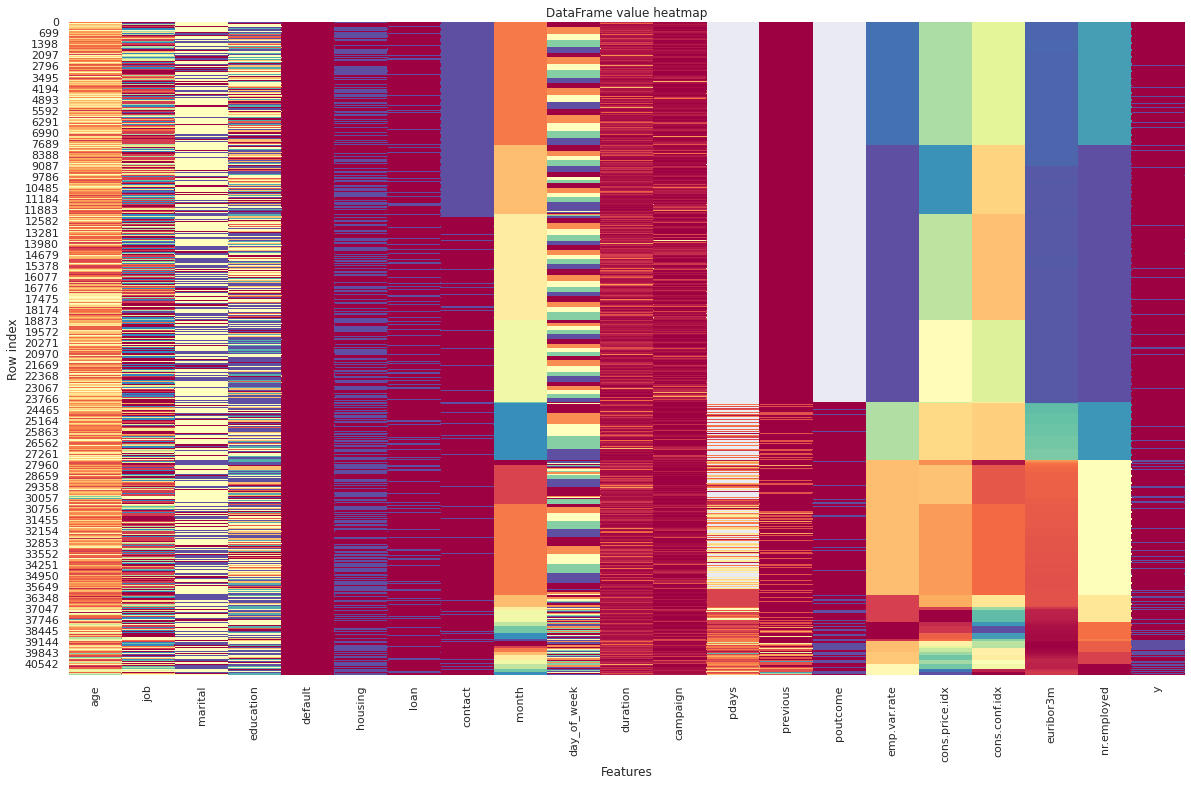

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(20, 12)}) # Why's the default size so small?

# Not so interested in values, so a diverging palette will do fine, and I don't care about the colour bar:
_ = sns.heatmap(df_scaled, cmap="Spectral", cbar = False)
plt.xlabel("Features")
plt.ylabel("Row index")
plt.title("DataFrame value heatmap")
plt.show()

This heatmap shows the variation between row values. So we can see that the samples aren't randomised; most striking is the observation that most cases when *pdays* and *poutcome* are missing — meaning that the client was not previously contacted — are at the start of the data (missing data is coded as grey). There also appears to be some ordering happening in the values of the features that were originally categorical. We can also see that we expect to observe some kind of linking relationship between 

* *emp.var.rate*: employment variation rate - quarterly indicator (numeric)
* *cons.price.idx*: consumer price index - monthly indicator (numeric)
* *cons.conf.idx*: consumer confidence index - monthly indicator (numeric)
* *euribor3m*: euribor 3 month rate - daily indicator (numeric)
* *nr.employed*: number of employees - quarterly indicator (numeric)

which are economic context attributes that vary temporally, as these all appear to be linked to *month*.

It's not clear from the heatmap, but there's also a strong correlation in the pattern of missingness in features *loan* and *housing*, which can be seen in the nullity correlation heatmap in the Pandas Profiling report above. However, it's possible to see this if we sort by either of these two features before plotting:


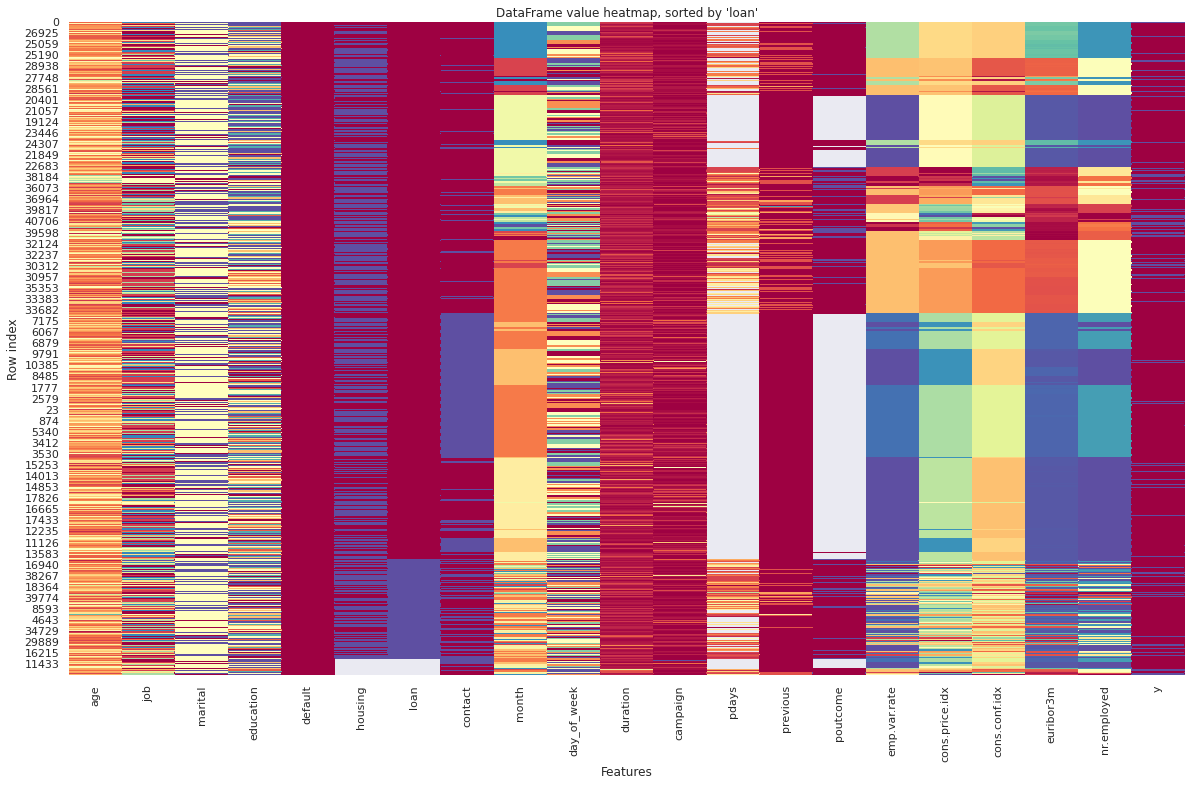

In [ ]:
sns.heatmap(df_scaled.sort_values(by = ["loan"]), cmap="Spectral", cbar = False)
plt.xlabel("Features")
plt.ylabel("Row index")
plt.title("DataFrame value heatmap, sorted by 'loan'")
plt.show()

Let's soup this up and reorder the rows and columns with hierarchical clustering and plot a nice dendrogram on both axes:

In [ ]:
! pip install fastcluster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


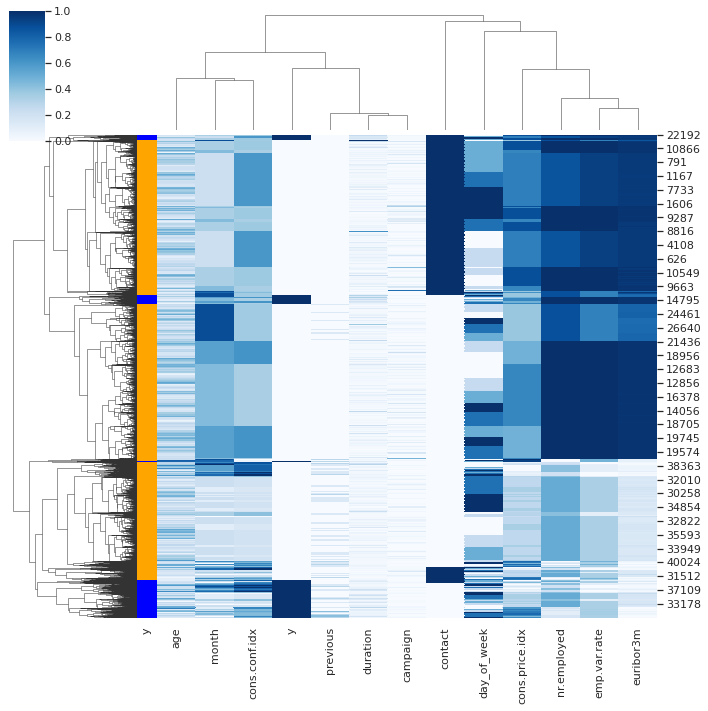

In [ ]:
# Prepare a vector of color mapped to the 'y' column
my_palette = dict(zip(df_numberfied.y.unique(), ["orange","blue"]))
row_colors = df_numberfied.y.map(my_palette)
 
# Plot, but ignore columns with missing data because this will make the clustering algo barf:
sns.clustermap(df_numberfied.dropna(axis = 1, how = "any"), cmap="Blues", standard_scale=1, row_colors=row_colors)
plt.show()

The cluster heatmap orders the items on the axes such that they are clustered according to similarity; the distance metric here is euclidean distance. It's difficult to see any patterns in the data here that we didn't see in the previous heatmaps.

Let's look for outliers in the numeric data:

In [ ]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
# Select the numeric data:
df_num = df.select_dtypes(include=np.number)
# I want to plot all the numeric features on the same boxplot and still see
# details for the features that have a smaller scale than others, so I'll scale
# all the features so that they're on the same scale:
scaled_data = scale.fit_transform(df_num.drop(columns = "y"), y = df_num["y"])
# Note that I didn't scale the target column:
scaled_data = pd.DataFrame(scaled_data, columns=df_num.columns[:-1])
# Add the target column back:
scaled_data = pd.concat([scaled_data, df_num["y"]], axis = 1)
# Pivot:
melted = pd.melt(scaled_data, id_vars = "y")

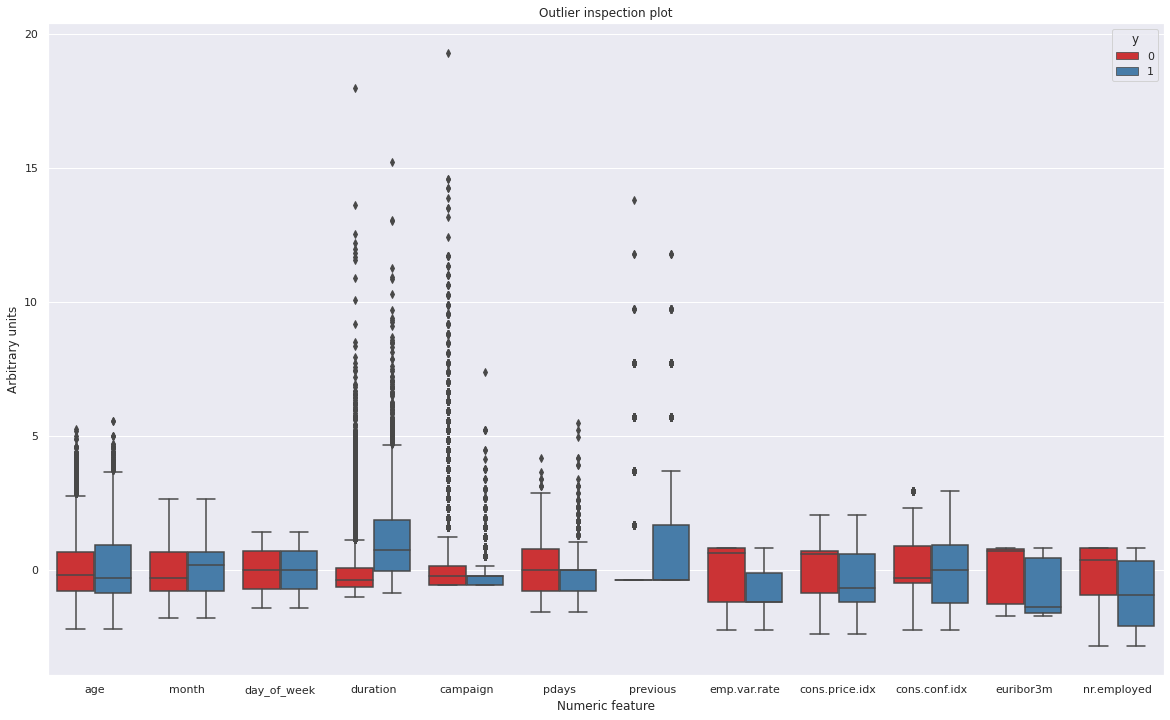

In [ ]:
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

sns.boxplot(
    x = "variable",
    y = "value", 
    data = melted, 
    hue = "y",
    palette="Set1"
    )
plt.xlabel("Numeric feature")
plt.ylabel("Arbitrary units")
plt.title("Outlier inspection plot")
plt.show()

Here we plot boxplots for all the (scaled) numeric features. We can use this plot to spot obvious outliers in the univariate distributions. It is clear that several of these distributions are skewed.

It's difficult to know, without knowledge from a domain expert, if any of these values are outliers that require attention, or if the distributions of these features simply have long tails. We don't seem to have *Methuselah* in our data — there's nobody with unrealistic ages. Some calls seemed to have a *duration* lasting about 1 and a half hours, but that might not be impossible. We can't know for sure without asking a subject-matter expert. In summary, we shouldn't blindly start omitting observations or Winsorizing/clipping feature values without input from someone who understands the data and the domain from which is corresponds.

I can try to use the *Modified Z-score method* described [here](https://medium.com/@joaopedroferrazrodrigues/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7) to detect outliers by calculating the Modified Z-score for each data point using the Median Absolute Deviation:

$$
M_i = \frac{0.6745\left(x_i - \tilde{x} \right)}{MAD}
$$

I set 5 as my cut off value. What I wanted to do next is change the marker properties on my boxplot such that the marker colour or type depends on whether the point is interpreted by this method to be an outlier, but it seems that Seaborn can't do this. Boo. Probably I could hack this together in Matplotlib.

In [ ]:
df_modifiedZscores = pd.DataFrame({var: 0.6745*(scaled_data[var] - scaled_data[var].median()) / scaled_data.mad()[var] for var in list(scaled_data.mad().index)})
melted_modifiedZscores = pd.melt(df_modifiedZscores, id_vars = "y")
melted_modifiedZscores["outlier"] = melted_modifiedZscores["value"] > 5
melted_modifiedZscores.loc[melted_modifiedZscores["outlier"]].head()

,y,variable,value,outlier
123601,0.000000,duration,5.838700,True
123639,3.373741,duration,5.481148,True
123652,3.373741,duration,5.056801,True
123728,0.000000,duration,7.280694,True
124010,3.373741,duration,5.669747,True


A scatterplot matrix can be a very effective way of getting a birds-eye view of the data... if you don't have too many columns. And then the utility isn't so great, and it takes forever to plot. For the sake of actually having done it, I tried to made a scatterplot matrix with all the features, but I downsampled the data a lot to speed up plotting. It crashed! So this next cell is commented out:

In [ ]:
# Plot the version of the data for which the categorical data is encoded as ordinal:
# sns.pairplot(df_numberfied.sample(frac = 0.01), kind="scatter", diag_kind="hist", hue="y")
# plt.show()
# Hot damn: I'm outta RAM! *crunch!* *bang!* :-(

Here I select just a few columns to plot, and only a small fraction of all the observations:

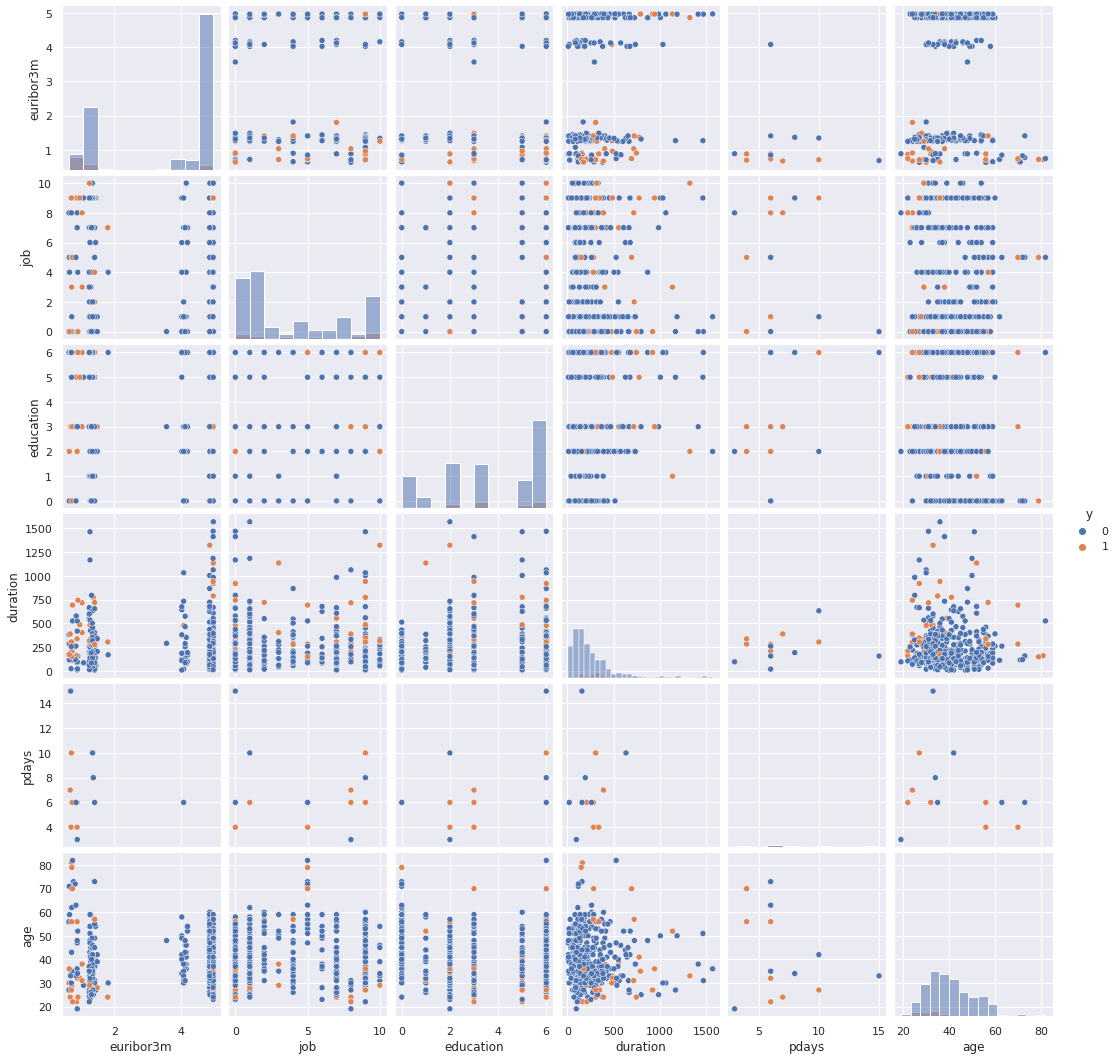

In [ ]:
sns.pairplot(
    df_numberfied[["euribor3m", "job", "education", "duration", "pdays", "age", "y"]].sample(frac = 0.01), 
    kind="scatter", diag_kind="hist", hue="y")
plt.show()

Personally — and I understand this may be perceived as a controversial opinion — I find correlation matrices rather useless when used out-of-the-box. The result is nearly always a wall of coloured tiles and/or numbers that isn't particularly informative. We can do better, though. We have the freedom to reorder the items being plotted on both axes rather than use the default order handed to us in the DataFrame. For example, we can use hierarchical clustering to define a new ordering based on the similarity between columns. We can also plot a dendrogram for this clustering, and in Seaborn this can be combined with a heatmap, as follows:

In [ ]:
! pip install fastcluster # Will speed up clustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


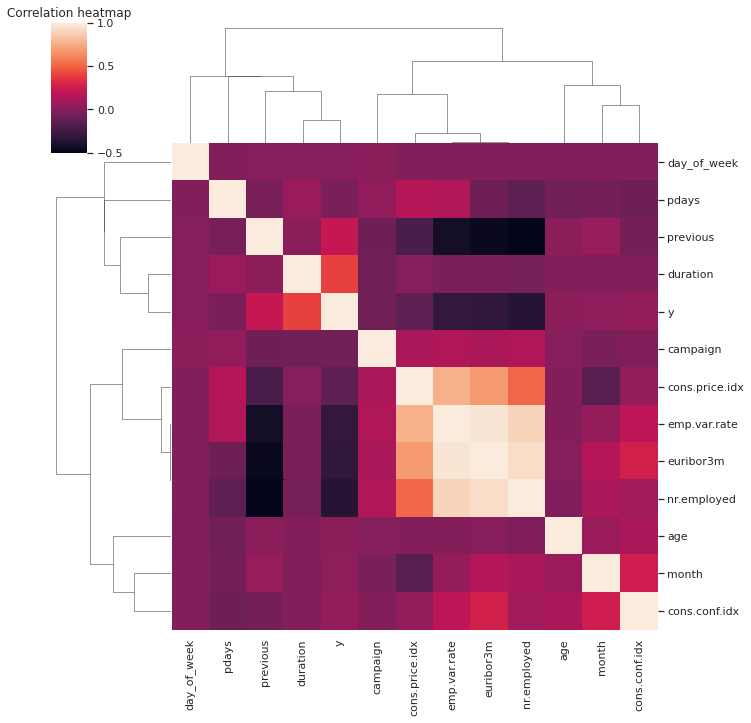

In [ ]:
# Plot Pearson correlation between pairs of numeric features and reorder the columns using 
# clustering with correlation as the distance metric and complete linkage as the linkage method:
sns.clustermap(df_num.corr(), metric='correlation', method = "complete")
plt.title("Correlation heatmap")
plt.show()

This is better than the default correlation heatmaps. We see that the economic indicator variables appear together on the axes, which makes the resultant correaltion heatmap more informative; we see that these features are all strongly correlated.

Let's spice things up a little. I'll create the (normalised) mutual information matrix for all columns. Each element in the matrix is the pairwise mutual information between features. I'm using a normalised variant of mutual information from sklearn; I believe (but have not confirmed) that the specific variant is the *symmetric uncertainty*:

$$
2\frac{I(X;Y)}{H(X) + H(Y)}.
$$

This normalised mutual information will be close to unity even if two features are not linearly or monotonicaly dependent on each other. That is, if we had two features, $x$ and $x^2$, we will expect the normalised mutual information to be equal to unity, indicating that there is a dependency relation between the two features. This would not be visible using Pearson's linear correlation coefficient or Spearman's rank correlation coefficient. 


I create a small function to calculate the MIM:

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

def pairwise_attributes_mutual_information(dataset):
    """Compute normalized mutual information for all pairwise attributes. Return a DataFrame."""
    mi_df = pd.DataFrame(columns=dataset.columns, index=dataset.columns, dtype=float)
    for row in mi_df.columns:
        for col in mi_df.columns:
            mi_df.loc[row, col] = normalized_mutual_info_score(dataset[row].astype(str),
                                                               dataset[col].astype(str))
    return mi_df

MIM = pairwise_attributes_mutual_information(df_numberfied)

In [ ]:
MIM.style.background_gradient(cmap="Blues") # Mutual Information Matrix

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.055936,0.052477,0.022229,0.013348,0.000806,0.001038,0.004003,0.021202,0.003024,0.106073,0.007378,0.011568,0.007752,0.006253,0.027688,0.042269,0.042269,0.079574,0.029901,0.007021
job,0.055936,1.000000,0.033946,0.211701,0.017501,0.000268,0.000286,0.006115,0.026639,0.000596,0.038119,0.002772,0.009687,0.006274,0.006640,0.027014,0.037691,0.037691,0.043825,0.029474,0.008156
marital,0.052477,0.033946,1.000000,0.016416,0.013580,0.000185,0.000057,0.003386,0.002914,0.000254,0.012035,0.000761,0.002867,0.002105,0.001950,0.006431,0.007498,0.007498,0.011611,0.006379,0.002258
education,0.022229,0.211701,0.016416,1.000000,0.024167,0.000274,0.000150,0.006377,0.018355,0.000667,0.025171,0.001931,0.003750,0.001746,0.001815,0.010900,0.021860,0.021860,0.026082,0.012355,0.002250
default,0.013348,0.017501,0.013580,0.024167,1.000000,0.000247,0.000108,0.015375,0.013302,0.000184,0.005906,0.001008,0.012078,0.013839,0.014686,0.029757,0.024262,0.024262,0.017756,0.030244,0.013350
housing,0.000806,0.000268,0.000185,0.000274,0.000247,1.000000,0.173070,0.004990,0.002407,0.000260,0.009791,0.000945,0.001404,0.000655,0.000535,0.002907,0.003947,0.003947,0.005807,0.002840,0.000121
loan,0.001038,0.000286,0.000057,0.000150,0.000108,0.173070,1.000000,0.000524,0.000504,0.000126,0.009181,0.000778,0.001231,0.000213,0.000039,0.000417,0.000905,0.000905,0.004197,0.000433,0.000030
contact,0.004003,0.006115,0.003386,0.006377,0.015375,0.004990,0.000524,1.000000,0.163657,0.001375,0.007329,0.003274,0.020067,0.063463,0.064051,0.235654,0.289889,0.289889,0.160344,0.230410,0.023097
month,0.021202,0.026639,0.002914,0.018355,0.013302,0.002407,0.000504,0.163657,1.000000,0.005708,0.034413,0.012230,0.026003,0.040572,0.042222,0.647303,0.870016,0.870016,0.529883,0.642492,0.024136
day_of_week,0.003024,0.000596,0.000254,0.000667,0.000184,0.000260,0.000126,0.001375,0.005708,1.000000,0.020038,0.003795,0.001951,0.000319,0.000296,0.003405,0.007795,0.007795,0.334560,0.003452,0.000328


Then, I plot the MIM as a force-directed network, removing edges that represent self correlation:

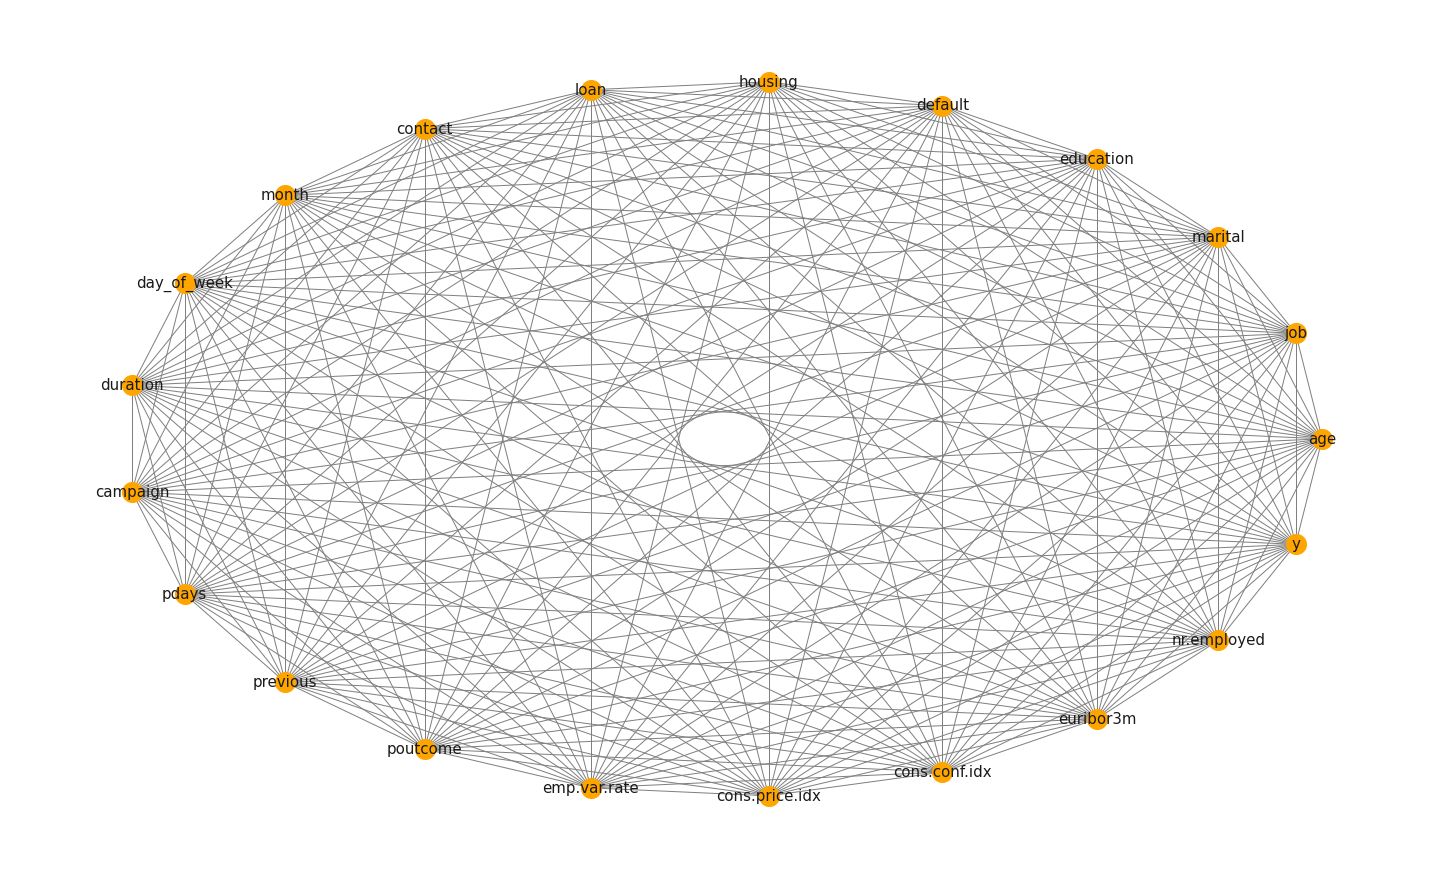

In [ ]:
import networkx as nx
 
# Transform MIM into a links data frame (3 columns only):
links = MIM.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['var1'] != links['var2']) ]
 
# Build graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
dir(nx)
# Plot the network:
nx.draw_kamada_kawai(G, with_labels=True, node_color='orange', node_size=400, edge_color='grey', linewidths=1, font_size=15)


This isn't useful without more manipulation. I'll clean this up by removing edges that represent low values of MI, corresponding to a weak relationship, between pairs of features. If single nodes are completely separated from a (sub-)graph, they won't be shown.

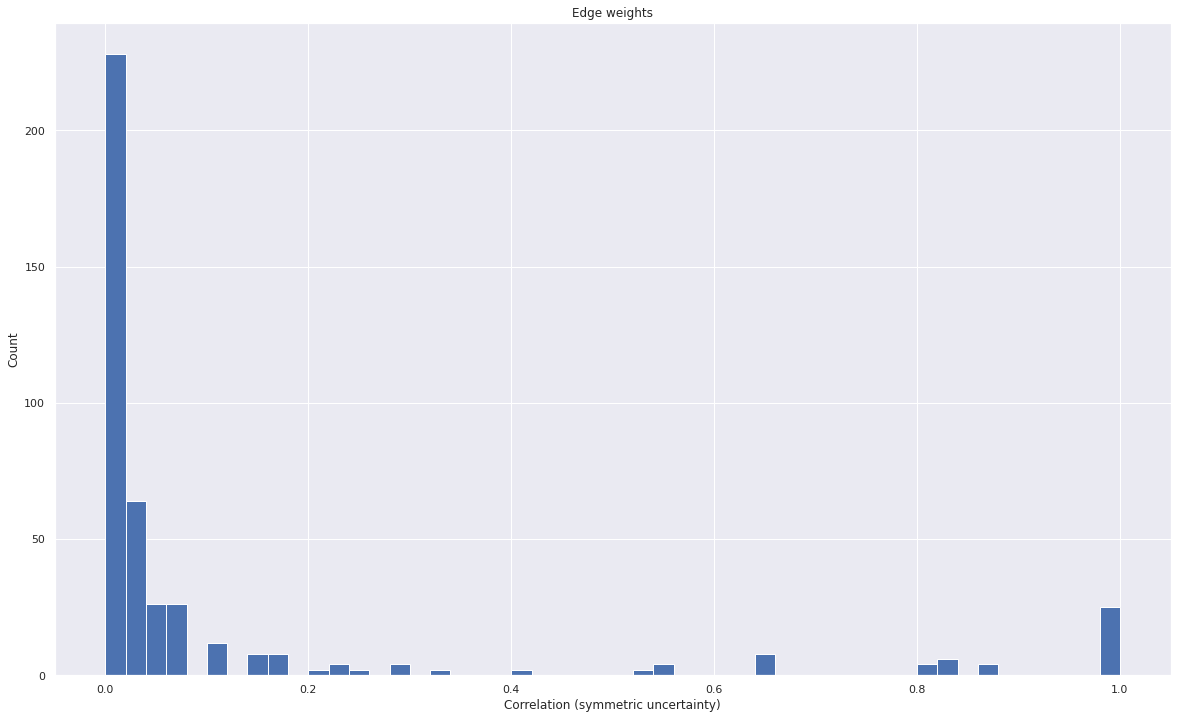

In [ ]:
links.hist(bins = 50) # Quick ad-hoc plot
plt.xlabel("Correlation (symmetric uncertainty)")
plt.ylabel("Count")
plt.title("Edge weights");

I'll set the threshold MI (somewhat arbitrarily) to eliminate edges corresponding to wear relationships; 0.2 seems to be reasonable:

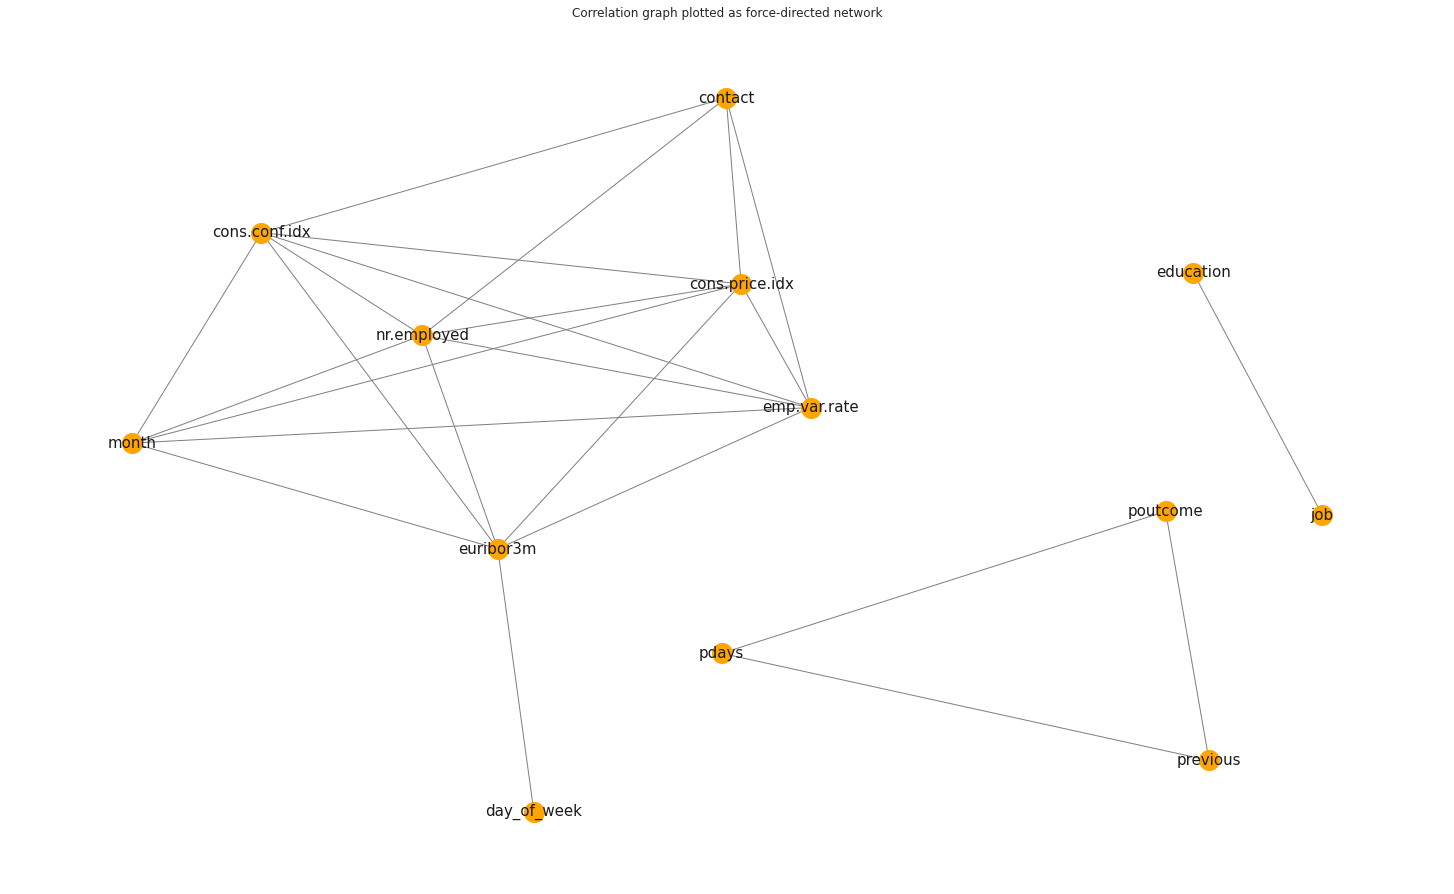

In [ ]:
# Keep only MI over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.2) & (links['var1'] != links['var2']) ]
 
# Build graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
dir(nx)
# Plot the network:
nx.draw_kamada_kawai(G, with_labels=True, node_color='orange', node_size=400, edge_color='grey', linewidths=1, font_size=15)
plt.title("Correlation graph plotted as force-directed network")
plt.show()

This indicates that *education* and *job* are related, as expected (well, d'uh!) and *pdays*, *previous* and *poutcome* are related (but we knew this already from the code book). The larger subgraph indicates that the economic indicators are related to each other, and there's some temporal relationship, indicated by the connections to *month* and *day_of_week*. We don't see the node for the target, so we can interpret this as meaning that there's no simple simple strong relationship between any feature and the target. We'll need to use consider combinations of two or more features to predict *y*.

Instead of an entropy-based metric, I could also try using [distance correlation](https://en.wikipedia.org/wiki/Distance_correlation); the correlation distance between $u$ and $v$, is defined as

$$
1 - \frac{(u - \bar{u}) \cdot (v - \bar{v})}{{\|(u - \bar{u})\|}_2 {\|(v - \bar{v})\|}_2}
$$

where $\bar{u}$ is the mean of the elements of $u$ and $x \cdot y$ is the dot product of $x$ and $y$.

It can be quite computationally expensive to calculate the distance correlation matrix, though, because it involves creating large distance matrices. This next cell takes a few minutes to run:

In [ ]:
from scipy.spatial import distance

def pairwise_attributes_distance_correlation(dataset):
    """Compute distance correlation for all pairwise attributes. Return a DataFrame."""
    dc_df = pd.DataFrame(columns=dataset.columns, index=dataset.columns, dtype=float)
    for row in dc_df.columns:
        for col in dc_df.columns:
            dc_df.loc[row, col] = distance.correlation(dataset[row], dataset[col])
    return dc_df

DistanceCorrelationMatrix = pairwise_attributes_distance_correlation(df_numberfied)

In [ ]:
DistanceCorrelationMatrix.style.background_gradient(cmap="Greens") # Distance Correlation Matrix

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,0.000000,nan,nan,nan,nan,nan,nan,0.992979,0.922735,1.018486,1.000866,0.995406,nan,0.975635,nan,1.000371,0.999143,0.870628,0.989233,1.017725,0.969601
job,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
marital,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
education,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
default,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
housing,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
loan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
contact,0.992979,nan,nan,nan,nan,nan,nan,0.000000,1.324315,0.980417,1.026657,0.922632,nan,1.212848,nan,0.606416,0.408526,0.748386,0.600227,0.730845,1.144773
month,0.922735,nan,nan,nan,nan,nan,nan,1.324315,0.000000,1.006959,1.019302,1.030635,nan,0.936246,nan,0.941126,1.150350,0.735773,0.836589,0.867303,0.962813
day_of_week,1.018486,nan,nan,nan,nan,nan,nan,0.980417,1.006959,0.000000,0.989451,0.984902,nan,0.995987,nan,1.004401,1.004586,1.000099,1.005552,1.000734,0.989949


In [ ]:
# Clean-up and start fresh:
del(links)
del(links_filtered)
del(G)
del(df_num)

# Transform distance correlation matrix into a links data frame (3 columns only):
links = DistanceCorrelationMatrix.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
 

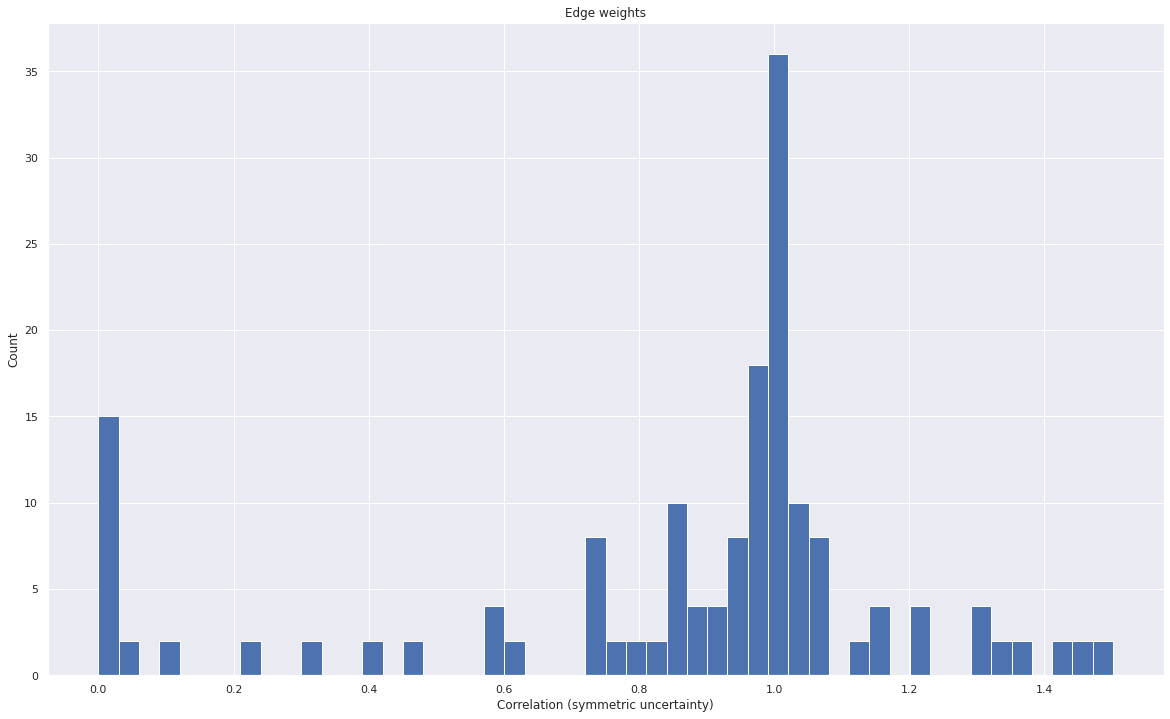

In [ ]:
links.hist(bins = 50) # Quick ad-hoc plot
plt.xlabel("Correlation (symmetric uncertainty)")
plt.ylabel("Count")
plt.title("Edge weights");

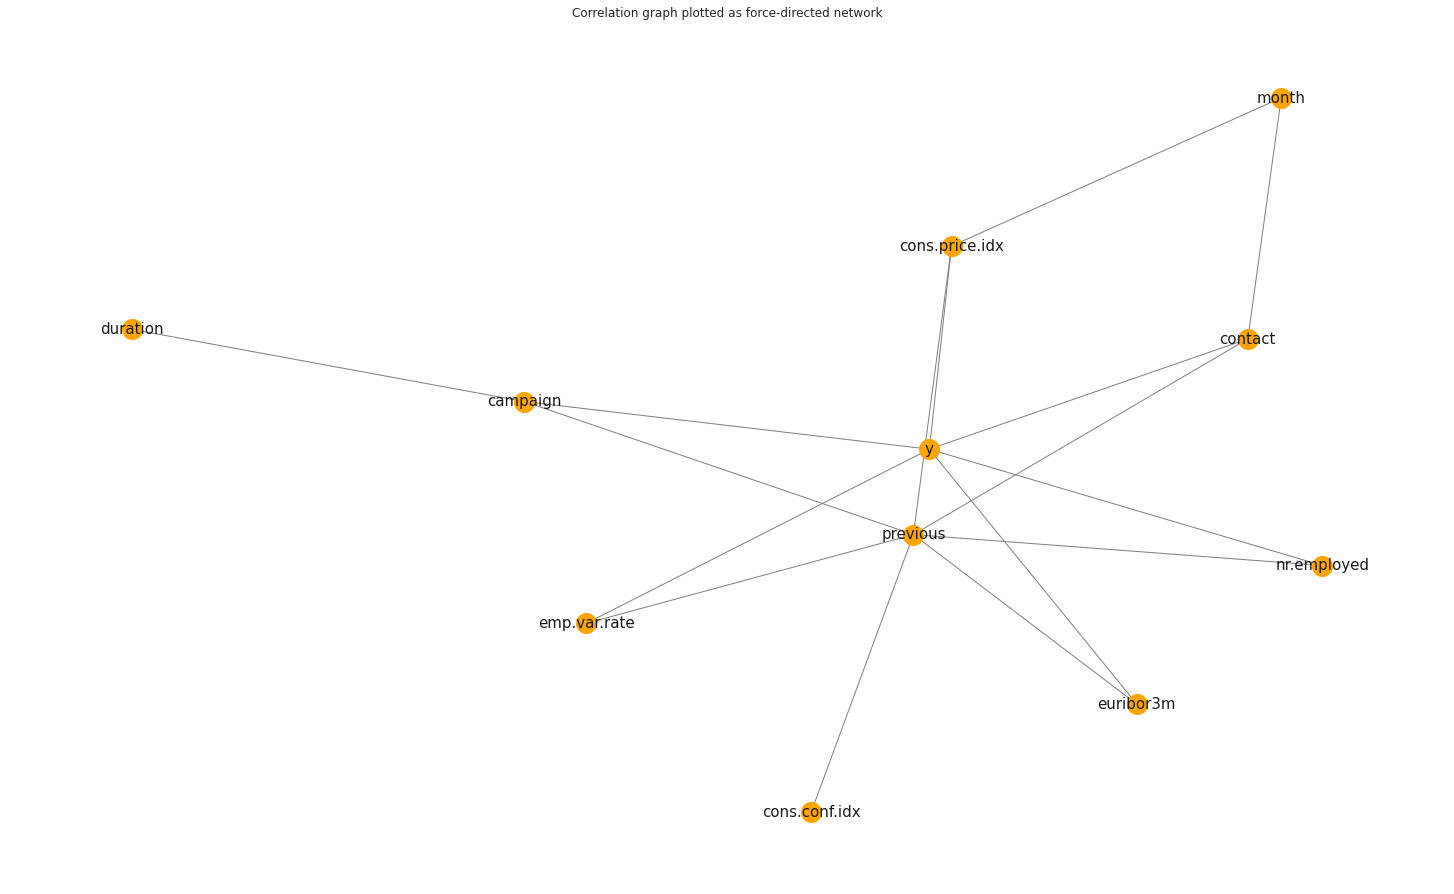

In [ ]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['var1'] != links['var2']) ]
 
# Build graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
links_filtered=links.loc[ (links['value'] > 1.05) & (links['var1'] != links['var2']) ]
 
# Build graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
# Plot the network:
nx.draw_kamada_kawai(G, with_labels=True, node_color='orange', node_size=400, edge_color='grey', linewidths=1, font_size=15)
plt.title("Correlation graph plotted as force-directed network")
plt.show()

The graph corresponding to the distance correlation matrix looks very different to the one corresponding to normalised mutual information, but still emphasises that economic indicators are important for predicting the target.

Let's try considering features separately.

Here's what I want to do: make a barplot of the feature *month*, grouped by *y*.

In [ ]:
counts = df_numberfied.groupby(["month", "y"]).y.agg([len]).reset_index()
counts.head()

,month,y,len
0,2,0,270
1,2,1,276
2,3,0,2093
3,3,1,539
4,4,0,12883


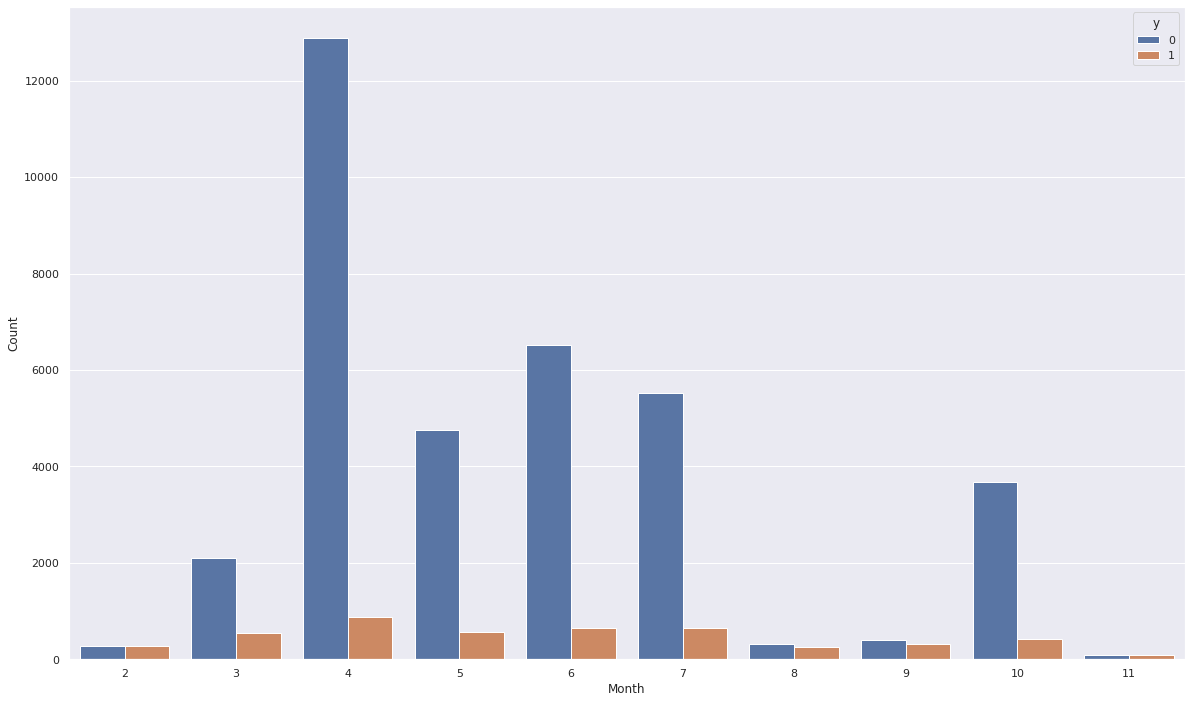

In [ ]:
sns.barplot(x="month", y="len", data = counts, hue="y")
plt.ylabel("Count")
plt.xlabel("Month")
plt.show()

It appears that there's not much activity during late summer and before and after Christmas — I guess that's not an optimal time to try to sell people a financial product over the phone! They've spent, or are planning to spend, money on holidays and Christmas instead?

Let's try plotting some economic indicators:

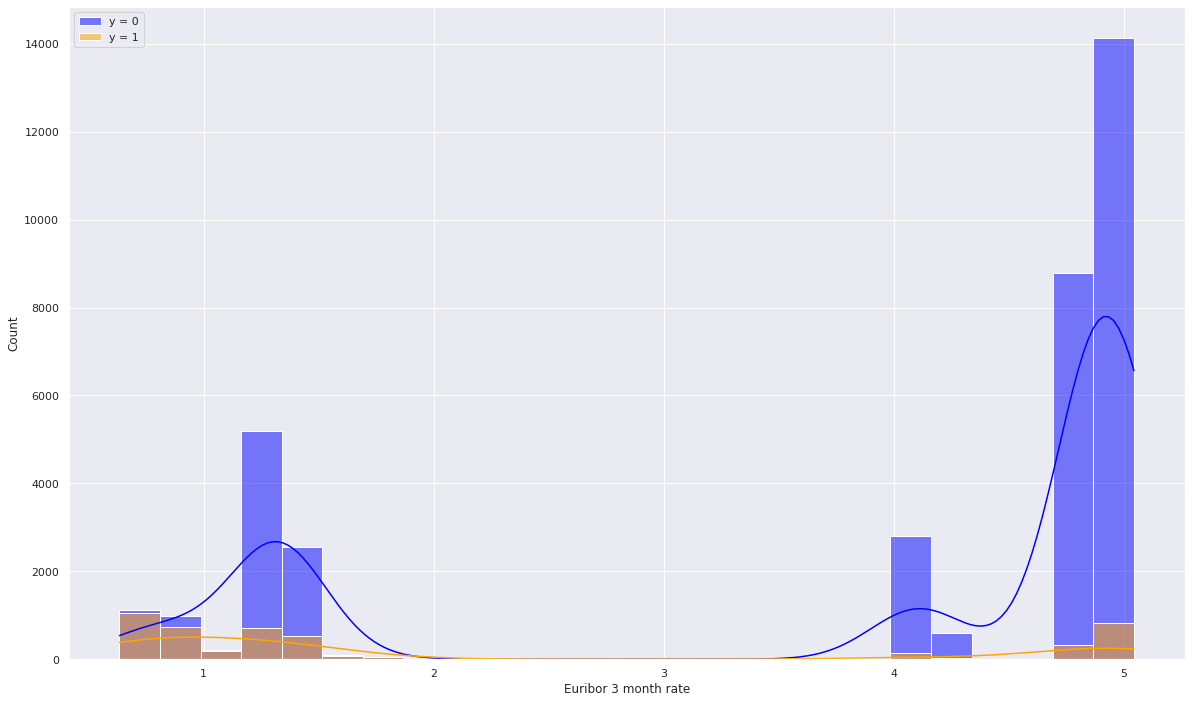

In [ ]:
sns.histplot(data=df_numberfied[df_numberfied.y == 0], x="euribor3m", color="blue", label="y = 0", kde=True, bins = 25)
sns.histplot(data=df_numberfied[df_numberfied.y == 1], x="euribor3m", color="orange", label="y = 1", kde=True, bins = 25)

plt.legend()
plt.xlabel("Euribor 3 month rate") 
plt.show()

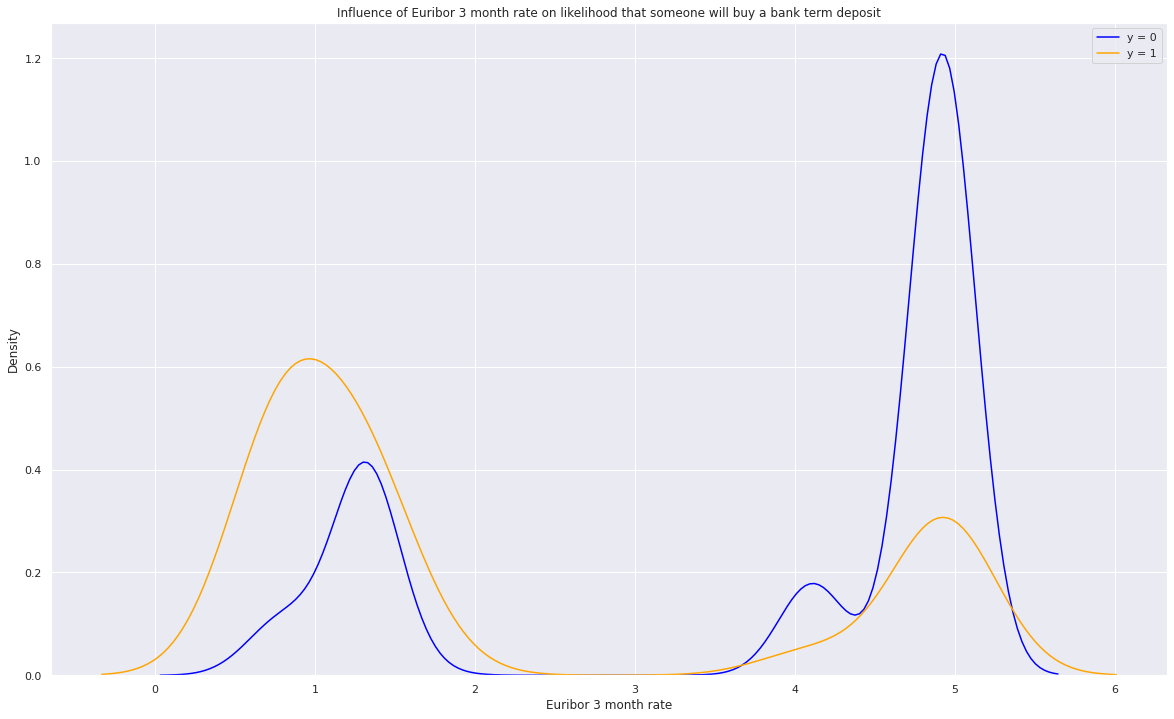

In [ ]:
sns.kdeplot(data=df_numberfied[df_numberfied.y == 0], x="euribor3m", color="blue", label="y = 0")
sns.kdeplot(data=df_numberfied[df_numberfied.y == 1], x="euribor3m", color="orange", label="y = 1")

plt.legend() 
plt.xlabel("Euribor 3 month rate")
plt.title("Influence of Euribor 3 month rate on likelihood that someone will buy a bank term deposit")
plt.show()

Euribor is the average interbank interest rate at which European banks are prepared to lend to one another. Since the Euribor rates are based upon agreements between many European banks, the level of the rates is determined by supply and demand in the first place. However there are some external factors, like economic growth and inflation which do influence the level of the rates as well. The interest rates of a Portuguese variable rate mortgages is linked to either the 3 or 6 month Euribor rate and increased by the margin (spread) that the bank applies. When Euribor is high it pushes up mortgage rates, so I'd expect that people are less likely to buy a financial product if they're struggling to pay the mortgage on their home. Indeed, it seems that there's a greater likelihood of people saying "yes" to buying a financial product when the Euribor 3 month rate is low, and vice versa when it is high.

Let's look at some joint distributions. I'll plot a scatterplot, and for fun I'll superpose it with a 2D KDE contour plot:

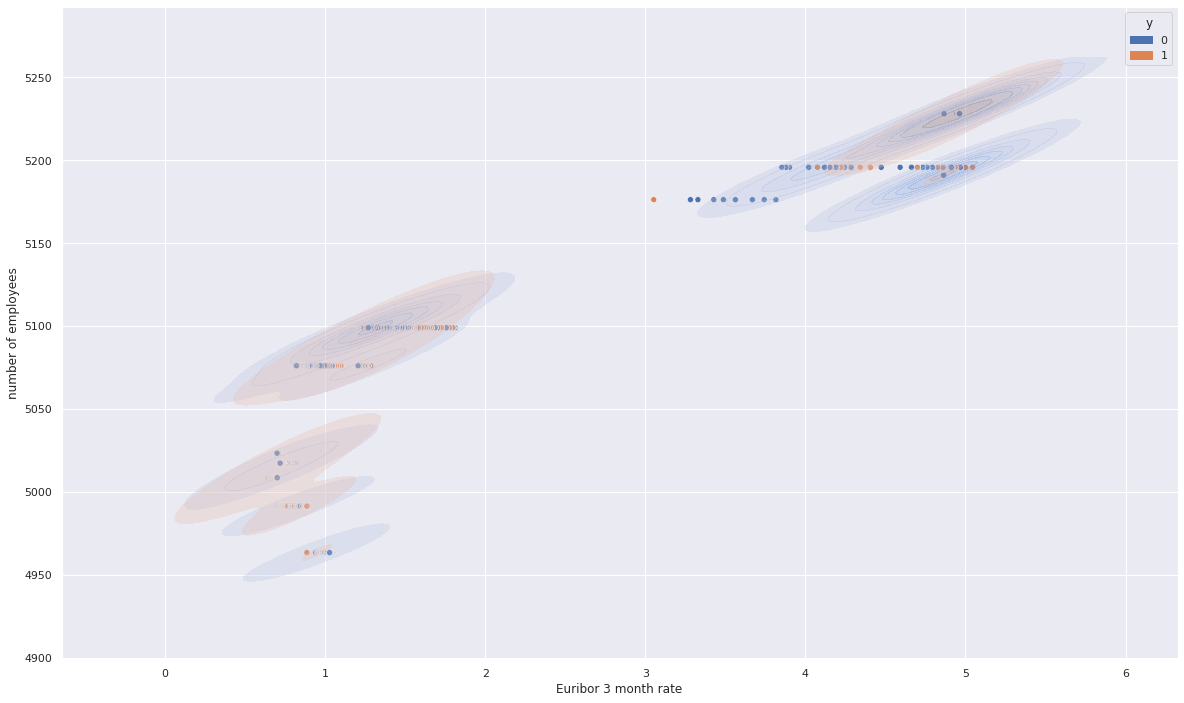

In [ ]:
sns.scatterplot(data = df_numberfied, x = "euribor3m", y = "nr.employed", hue = "y")
sns.kdeplot(data = df_numberfied, x = "euribor3m", y = "nr.employed", hue = "y", fill = True, alpha = 0.3)
plt.xlabel("Euribor 3 month rate")
plt.ylabel("number of employees");

I'll next make a parallel coordinates plot to examine relationships between features:

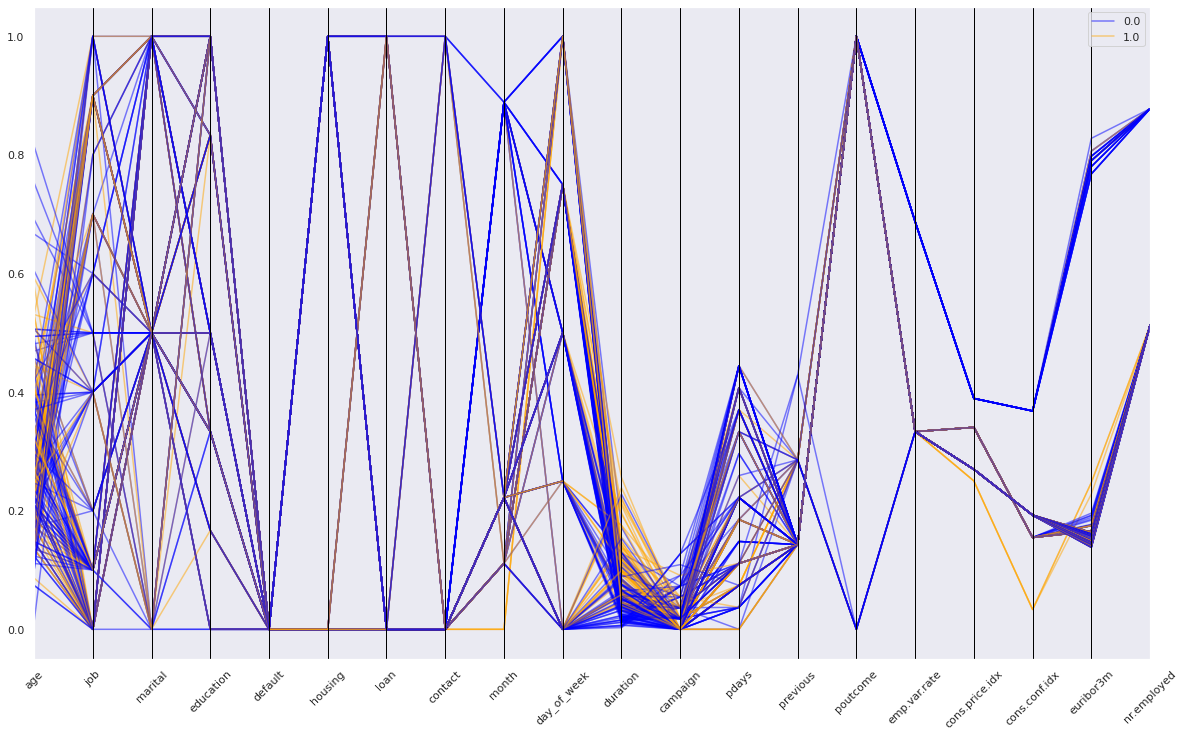

In [ ]:
from pandas.plotting import parallel_coordinates

# Need to scale all the features, apparently:
parallel_coordinates(df_scaled.dropna().head(200), 'y', color=['blue', 'orange'], alpha = 0.5)
plt.xticks(rotation = 45);

Spaghetti! OK, that wasn't too enlightening. Maybe *cons.conf.idx* could be a useful feature in a classifier for predicting the target?

OK, what's left to do for this part?

The homework says, "try to introduce new features to consider their relationship with other features". OK, let's do polynomial (degree 2) feature expansion:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

df_numberfied_no_missing = df_numberfied.dropna(axis = 1).drop(columns = "y")
p = PolynomialFeatures(degree=2).fit(df_numberfied_no_missing)
df_expanded = pd.DataFrame(p.transform(df_numberfied_no_missing), columns=p.get_feature_names_out(df_numberfied_no_missing.columns))
del(df_numberfied_no_missing)

In [ ]:
df_expanded.columns # We have new columns in our design matrix (and an intercept term)

Index(['1', 'age', 'contact', 'month', 'day_of_week', 'duration', 'campaign',
       'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'age^2', 'age contact', 'age month',
       'age day_of_week', 'age duration', 'age campaign', 'age previous',
       'age emp.var.rate', 'age cons.price.idx', 'age cons.conf.idx',
       'age euribor3m', 'age nr.employed', 'contact^2', 'contact month',
       'contact day_of_week', 'contact duration', 'contact campaign',
       'contact previous', 'contact emp.var.rate', 'contact cons.price.idx',
       'contact cons.conf.idx', 'contact euribor3m', 'contact nr.employed',
       'month^2', 'month day_of_week', 'month duration', 'month campaign',
       'month previous', 'month emp.var.rate', 'month cons.price.idx',
       'month cons.conf.idx', 'month euribor3m', 'month nr.employed',
       'day_of_week^2', 'day_of_week duration', 'day_of_week campaign',
       'day_of_week previous', 'day_of_week emp.var.

OK, I'm out of ideas. I've no more ideas what I'm supposed to do for this part of the homework.

## Part 2: Data preparation

The homework says:

> Prepare data to dimensionality reduction step: 
 * Fill missing values if needed, explain the selected strategy - 2 points
 * Deal with outliers  if needed, explain the selected strategy - 2 points
 * Prepare categorical data if needed - 2 points

 However, I already did all of this earlier — see above. I'll explain here what I did, and describe some other steps that I can take as part of data preperation.

 ### "Fill missing values if needed, explain the selected strategy"

As can be seen below, the data had no explicit missing data:

In [ ]:
pd.read_csv("./bank-additional/bank-additional-full.csv", sep = ";").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

There appear to be a bunch of categorical features that code missing data as "unknown". *pdays* is the number of days that passed by after the client was last contacted from a previous campaign; 999 means the client was not previously contacted. I coded that as explicitly missing. If I did not do this the value of 999 will manifest as an outlier. *poutcome* is the outcome of the previous marketing campaign; "nonexistent" means the client wasn't previously contacted. I coded that as explicitly missing, as I did for when *pdays* has the value 999, as the meaning of these two values are linked.

The missing data is missing not at random (MNAR). The missing data is not missing because there ought to be a value there; the "missingness" of the value itself conveys information. For example, if the client was not previously contacted, *pdays*, the number of days that have passed after the client was last contacted from a previous campaign, is missing. It does not make sense to impute! Imputation would be entirely the wrong strategy here!

We don't have data for months January and December. We could try imputing, but we don't know the target values for these months, so this doesn't seem wise. Moreover, there are categorical features with missing values, but it's not clear if we should try to impute them.

I could try multivariate feature imputation to impute missing values, after I've converted the categorical features for numeric, but afterwards I need to figure out a mapping from the new numeric values back to appropriate categorical features. What is the meaning of *default* = 0.000364?

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_numberfied)
pd.DataFrame(imp.transform(df_numberfied), columns = df_numberfied.columns).head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,3.0,1.0,0.0,0.000000,0.0,0.0,1.0,4.0,0.0,...,1.0,11.203648,0.0,0.024678,1.1,93.994,-36.4,4.857,5191.0,0.0
1,57.0,7.0,1.0,3.0,0.000364,0.0,0.0,1.0,4.0,0.0,...,1.0,10.063391,0.0,0.037265,1.1,93.994,-36.4,4.857,5191.0,0.0
2,37.0,7.0,1.0,3.0,0.000000,1.0,0.0,1.0,4.0,0.0,...,1.0,10.431030,0.0,0.031203,1.1,93.994,-36.4,4.857,5191.0,0.0
3,40.0,0.0,1.0,1.0,0.000000,0.0,0.0,1.0,4.0,0.0,...,1.0,11.399902,0.0,0.026539,1.1,93.994,-36.4,4.857,5191.0,0.0
4,56.0,7.0,1.0,3.0,0.000000,0.0,1.0,1.0,4.0,0.0,...,1.0,9.692984,0.0,0.034744,1.1,93.994,-36.4,4.857,5191.0,0.0


We can also use `CategoricalImputer` from sklearn, and this apparently replaces missing values with the most frequent ones in that column. That might not be a good strategy. Maybe we can use Markov chains? In any case, it's unclear whether there would be any benefit in imputing.

### "Deal with outliers if needed, explain the selected strategy"

The value 999 is the missing value indicator for the *pdays* feature; if I did not encode this as explicitely missing it would be an outlier value.

### "Prepare categorical data if needed"

I manually encoded the *month* and *day_of_week* categorical variables as ordinal because their ordering has (temporal) meaning and I wanted to ensure an explicit ordering that matches expectations. I used sklearn's `OrdinalEncoder` to encode the remaining categorical features as numeric.

### What else can we do here?

It can be seen that a number of features have distributions that are skewed. We might want to make their distributions more Gaussian-like to assist with some machine learning models. One usually applies a log transform to do this. However, it's not the only transform we can apply.

John Tukey designed a family of power transformations to promote symmetry and linearity relationships:

$$
y^3\\
y^2\\
y^1 \mathrm{(no\ transform)}\\
\sqrt{y}\\
\log{y}\\
-1/\sqrt{y}\\
-1/y\\
-1/y^2\\
$$

One chooses a transformation and then plots the data to see how the transformation has affected the data. If necessary, we move up or down the ladder to reduce the skew. The range of possible transformations with Tukey’s ladder is much more restricted than with the Box-Cox transformation. Box-Cox transformations are themselves limited to transforming data with values greater than zero. Yeo-Johnson transformations don't have this restriction. Applying the transformaton usually amounts to finding the optimal parameters; we can then visually inspect the resultant transformed data using a Q-Q plot:

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson', standardize = True) # Actually the default param values; will do mean removal and variance scaling
y = df_numberfied["y"]
df_yj = pt.fit_transform(df_numberfied)
df_yj = pd.DataFrame(df_yj, columns = df_numberfied.columns)
df_yj["y"] = y
df_yj.head()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3218: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1.427459,0.208785,-0.289705,-1.758605,-0.009595,-1.076397,-0.428993,1.31827,-0.779407,-1.487646,...,-1.045497,NaN,-0.397706,NaN,0.561017,0.700791,0.911782,0.71366,0.140827,0
1,1.492292,1.004810,-0.289705,-0.283455,NaN,-1.076397,-0.428993,1.31827,-0.779407,-1.487646,...,-1.045497,NaN,-0.397706,NaN,0.561017,0.700791,0.911782,0.71366,0.140827,0
2,-0.158076,1.004810,-0.289705,-0.283455,-0.009595,0.929026,-0.428993,1.31827,-0.779407,-1.487646,...,-1.045497,NaN,-0.397706,NaN,0.561017,0.700791,0.911782,0.71366,0.140827,0
3,0.150155,-1.298405,-0.289705,-1.259648,-0.009595,-1.076397,-0.428993,1.31827,-0.779407,-1.487646,...,-1.045497,NaN,-0.397706,NaN,0.561017,0.700791,0.911782,0.71366,0.140827,0
4,1.427459,1.004810,-0.289705,-0.283455,-0.009595,-1.076397,2.331038,1.31827,-0.779407,-1.487646,...,-1.045497,NaN,-0.397706,NaN,0.561017,0.700791,0.911782,0.71366,0.140827,0


Here's what the *duration* feature looks like before transformation:

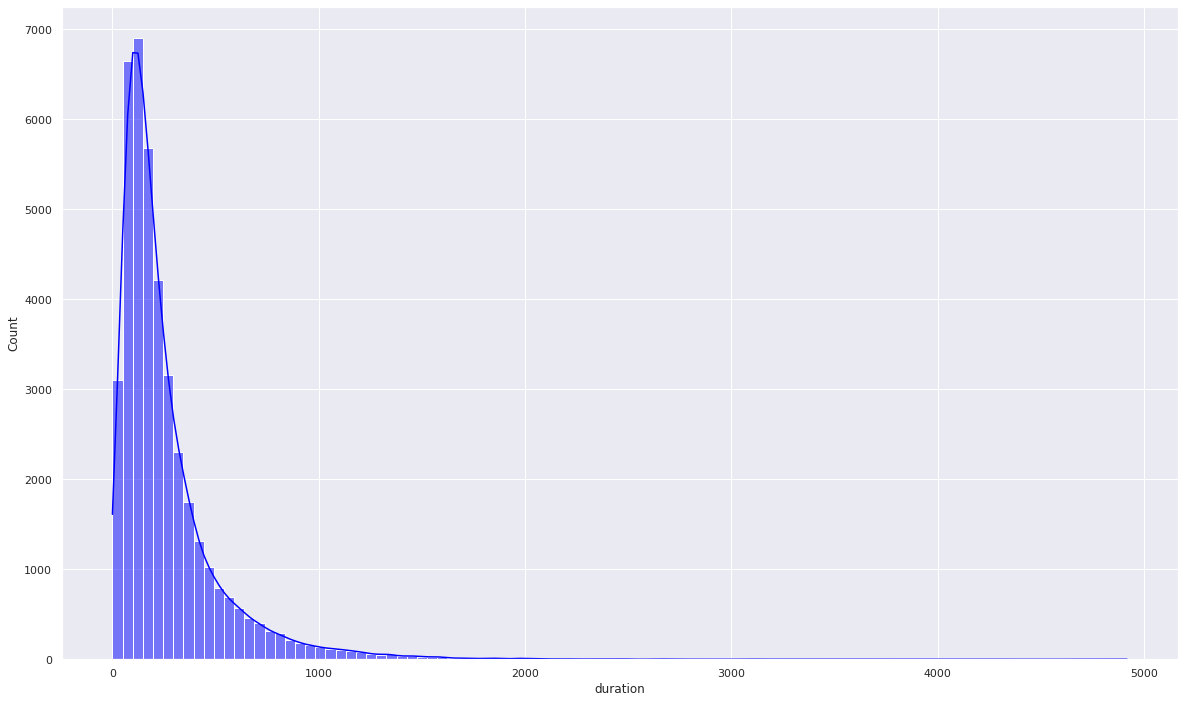

In [ ]:
sns.histplot(data=df_numberfied, x="duration", color="blue", kde=True, bins = 100);

Here's what the *duration* feature looks like after transformation:

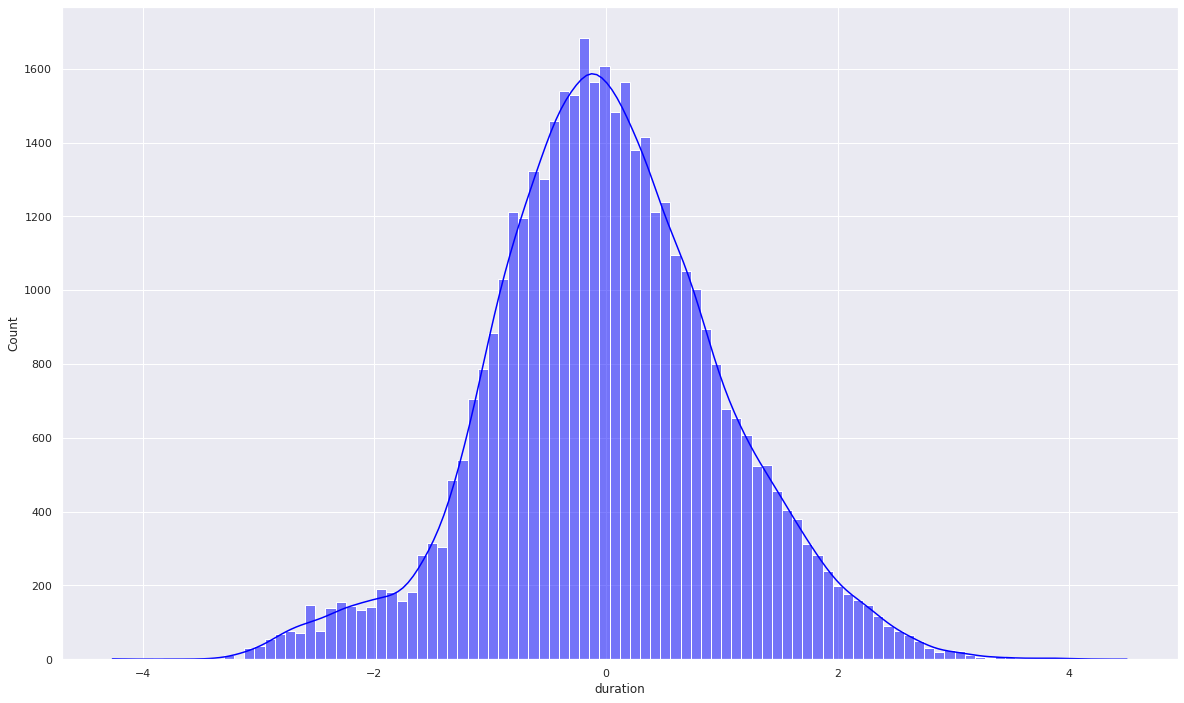

In [ ]:
sns.histplot(data=df_yj, x="duration", color="blue", kde=True, bins = 100);

That looks very Gaussian-like, but we can confirm this using a Q-Q plot:

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


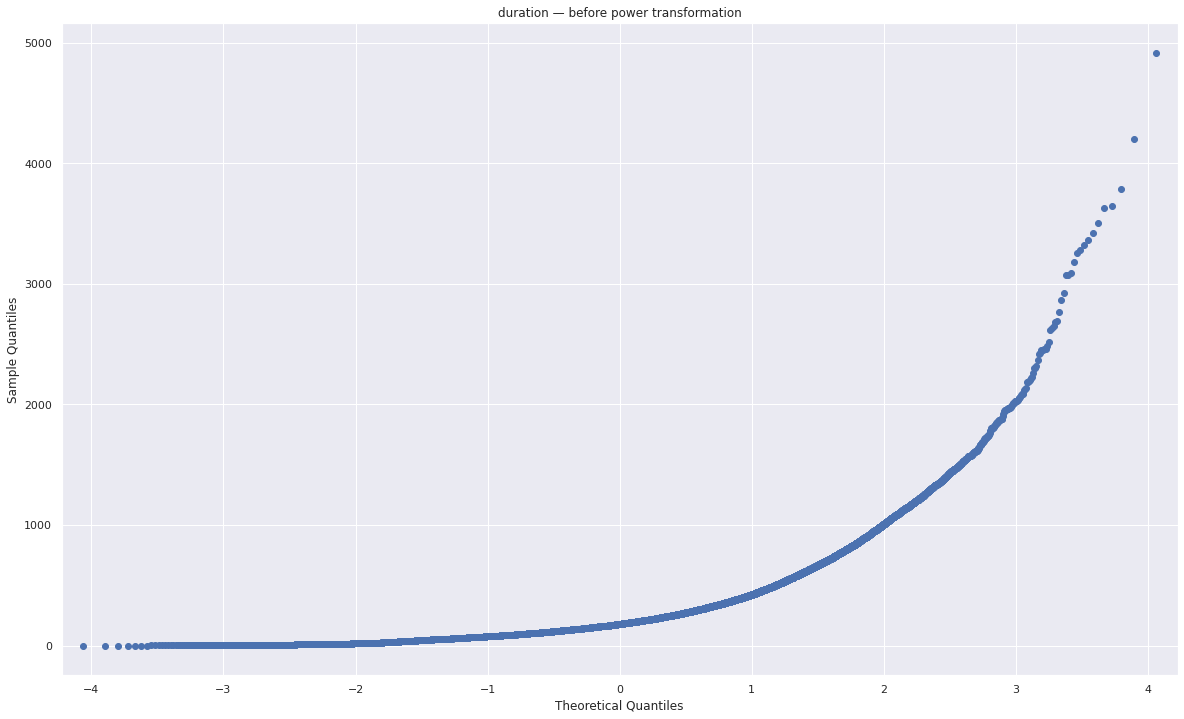

In [ ]:
import statsmodels.api as sm

sm.qqplot(df_numberfied["duration"])
plt.title("duration — before power transformation")
plt.show();

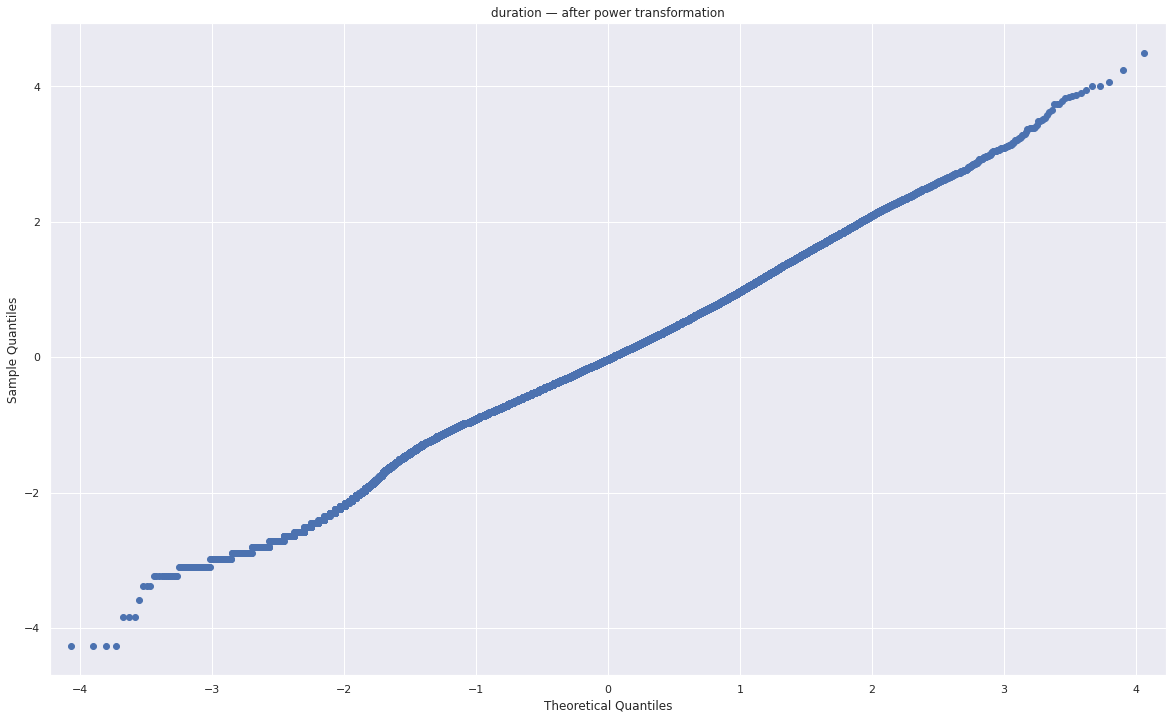

In [ ]:
sm.qqplot(df_yj["duration"])
plt.title("duration — after power transformation")
plt.show();

That seems to confirm that the *duration* feature now closely follows a Gaussian distribution. We can inspect other features similarly:

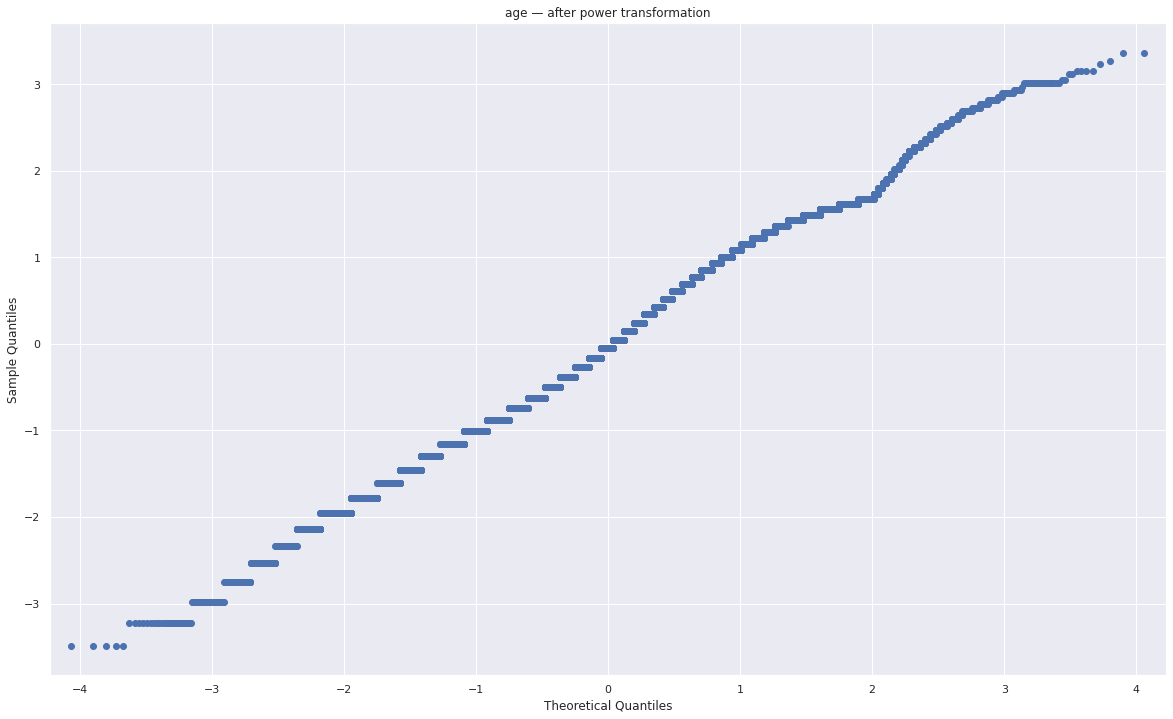

In [ ]:
sm.qqplot(df_yj["age"])
plt.title("age — after power transformation")
plt.show()

## Part 3: Dimensionality Reduction


We need to install some modules that are not available in Colab by default, and unfortunately PHATE appears to have some dependendies on things that are not in the default runtime setup of Colab, so this can cause problems. It's best to restart the runtime before starting.

In [ ]:
! pip install --user --upgrade phate
! pip install trimap
! pip install umap-learn
! pip install pacmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


I found that dimensionality reduction algorithms can be both time- and RAM-consuming, so it's best to downsample the data. I also drop columns that having missing data, because this can cause problems, and I also drop the *duration* column that leaks information about the target and therefore should not be used for building a predictive model:

In [ ]:
# Need to drop columns with missing data, and downsample the data to prevent running out of RAM:
DF = df_yj.dropna(axis = 1).sample(frac = 0.05)
y = DF["y"].to_numpy()
DF = DF.drop(columns = "y") # Drop target
# duration leaks information about the target; remove it and poly terms depending on it:
DF = DF[DF.columns.drop(list(DF.filter(regex="duration")))] 
DF.columns # Check

Index(['age', 'contact', 'month', 'day_of_week', 'campaign', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')

In [ ]:
import sklearn.decomposition # PCA
import sklearn.manifold # MDS, t-SNE
import phate
import trimap
import umap
import pacmap
import warnings
warnings.filterwarnings('ignore') # Some of these algos should be less chatty

operators = {
    "PCA": sklearn.decomposition.PCA(n_components=2),
    "MDS": sklearn.manifold.MDS(n_components=2, metric=True, n_jobs=-2),
    "t-SNE": sklearn.manifold.TSNE(n_components=2),
    "PHATE": phate.PHATE(n_jobs=-2),
    "TriMap": trimap.TRIMAP(),
    "UMAP": umap.UMAP(),
    "PaCMAP": pacmap.PaCMAP(),
    "Isomap": sklearn.manifold.Isomap()
}

embeddings = {name: operator.fit_transform(DF.to_numpy()) for name, operator in operators.items()}

# pca_operator = sklearn.decomposition.PCA(n_components=2)
# embedding_pca = pca_operator.fit_transform(DF)

# mds_operator = sklearn.manifold.MDS(n_components=2, metric=True, n_jobs=-2)
# embedding_mds = mds_operator.fit_transform(DF)

# tsne_operator = sklearn.manifold.TSNE(n_components=2)
# embedding_tsne = tsne_operator.fit_transform(DF)

# phate_operator = phate.PHATE(n_jobs=-2)
# embedding_phate = phate_operator.fit_transform(DF)

# trimap_operator = trimap.TRIMAP()
# embedding_trimap = trimap_operator.fit_transform(DF.to_numpy())

# umap_operator = umap.UMAP()
# embedding_umap = umap_operator.fit_transform(DF)

# pacmap_operator = pacmap.PaCMAP()
# embedding_pacmap = pacmap_operator.fit_transform(DF.to_numpy(), init="pca")

# isomap_operator = sklearn.manifold.Isomap()
# embedding_isomap = isomap_operator.fit_transform(DF)

ModuleNotFoundError: ignored

Plot the results of dimensionality reduction using different methods:

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
subplots = axes.ravel()

# PHATE comes with a nice plotting function for comparing different dimensionality reduction methods, so I'll use that:

for i, (name, embedding) in enumerate(embeddings.items()):
  if i == 8: # Nothing to fill this subplot
    break
  phate.plot.scatter2d(embedding, label_prefix=name, s=10,
                       c=y, title=name, legend=False, ax=subplots[i])

# # plotting PCA
# phate.plot.scatter2d(embedding_pca, label_prefix="PC", s=10, 
#                      c=y, title="PCA", 
#                      legend=False, ax=ax1);

# # plotting metric MDS
# phate.plot.scatter2d(embedding_mds, label_prefix="MDS", s=10, 
#                      c=y, title="Metric MDS", 
#                      legend=False, ax=ax2);

# # plotting tSNE
# phate.plot.scatter2d(embedding_tsne, label_prefix="t-SNE", s=10, 
#                      c=y, title="t-SNE", 
#                      legend=False, ax=ax3);

# # plotting PHATE
# phate.plot.scatter2d(embedding_phate, label_prefix="PHATE", s=10, 
#                      c=y, title="PHATE", 
#                      legend=False, ax=ax4);

# # plotting TriMap
# phate.plot.scatter2d(embedding_trimap, label_prefix="TriMap", s=10, 
#                      c=y, title="TriMap", 
#                      legend=False, ax=ax5);

# # plotting UMAP
# phate.plot.scatter2d(embedding_umap, label_prefix="UMAP", s=10, 
#                      c=y, title="UMAP", 
#                      legend=False, ax=ax6);

# # plotting PaCMAP
# phate.plot.scatter2d(embedding_pacmap, label_prefix="PaCMAP", s=10, 
#                      c=y, title="PaCMAP", 
#                      legend=False, ax=ax7);

# # plotting Isomap
# phate.plot.scatter2d(embedding_isomap, label_prefix="Isomap", s=10, 
#                      c=y, title="Isomap", 
#                      legend=False, ax=ax8);

subplots[8].set_axis_off() # hide unused axis
plt.tight_layout()
plt.show()

Exploring PCA in more detail, I'm going to plot a scree plot that shows the varianced explained by the principle components, and a biplot that shows the loading vectors:

In [ ]:
! pip install pca

In [ ]:
from pca import pca

DF = df_yj.dropna(axis = 1)
y = DF["y"]
DF = DF.drop(columns = "y") # Drop target

# Initialize to reduce the data up to the number of componentes that explains 95% of the variance:
model = pca(n_components=0.95, normalize = True)

# Or reduce the data towards 2 PCs:
# model = pca(n_components=2, normalize = True)

# Fit transform:
results = model.fit_transform(DF, col_labels = DF.columns, row_labels = y)

# Plot explained variance:
fig, ax = model.plot();

There's no small number of components that capture most of the variance in the data; that is, the first two components capture about 47% of the variance in the data, and half the number of principle components as there are feature to capture 80% of the variance.

In [ ]:
# Make biplot:
fig, ax = model.biplot(n_feat = 3, label = True, y = y, alpha_transparency = 0.5, gradient='#FFFFFF', cmap = "Set3", legend = True) # I don't want to label all the data points with row indices

It appears that PC1 captures some of the difference between the two target classes; we see that more cases of *y* = 1 are to the right than to the left. The loading vectors are shown, and it seems that the economic indicator *euribor3m* explains most of this difference. We can extract the features that are most important in the PCA reduction; *euribor3m* is the most important feature:

In [ ]:
results['topfeat']



Make a 3D biplot showing the loading vectors:

In [ ]:
# Make 3D biplot with the number of features:
fig, ax = model.biplot3d(n_feat = 3, label = True, y = y, alpha_transparency = 0.5, gradient='#FFFFFF', cmap = "Set3", legend = True) # I don't want to label all the data points with row indices

Here's the versions of the modules we used:

In [ ]:
%watermark --iversions

pandas     : 1.3.5
scipy      : 1.7.3
pacmap     : 0.6.3
umap       : 0.5.3
IPython    : 5.5.0
requests   : 2.28.0
networkx   : 2.6.3
phate      : 1.0.8
matplotlib : 3.2.2
sklearn    : 0.0
statsmodels: 0.10.2
seaborn    : 0.11.2
trimap     : 1.1.4
numpy      : 1.21.6



# Notes from PDP meeting (2022-96-27):
* Tighten up code with for loops to reduce code duplication **(DONE)**
* Explain UMAP **(DONE — see below)**
* Need to work faster; sacrifice quality for speed — need to demonstrate progress

# UMAP explained

UMAP (Uniform Manifold Approximation and Projection) uses graph layout algorithms to arrange data in low-dimensional space. UMAP builds a neighbour graph in the original space of the data and tries to find a similar graph in lower dimensions. Key steps:
1. Construction of a graph in the original space
  
  * Each data point is a 0-simplex. The topology of the data in the original space is approximated by combining these data points with their nearest neighbours to form 1-, 2-, or higher-dimensional simplicies. For this, the UMAP algorithm extends a radius around each data point and makies a connection between each point and it's neighbours in intersecting radii. The radius is allowed to be variable to account for variations in the density of points in the original space. The radius is large in low density regions and small in high density regions. UMAP uses the distance to the $k_\mathrm{th}$ nearest neighbour of each point for the density estimation to determine the optimal local radius for each point.

  * Connections between data points (nodes in the graph) get a weight; these edge weights are smaller for points that are far away from each other and larger for points that are close together.
2. Projection of the graph into lower dimensions

  * Once the high-dimensional graph is constructed, UMAP optimizes the layout of a low-dimensional analogue to be as similar as possible, such that points that are connected in the high-dimensional graph with a large edge weight are closer in the low-dimensional analogue than those with a small edge weight.

The most commonly used parameters are `n_neighbors` and `min_dist`. Of these, the former is the most important, and controls the balance between local and global structure in the final projection. `n_neighbors` is the number of approximate nearest neighbors used to construct the initial high-dimensional graph. Low values will push UMAP to focus more on local structure by constraining the number of neighbouring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail. `min_dist` is the minimum distance between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings.

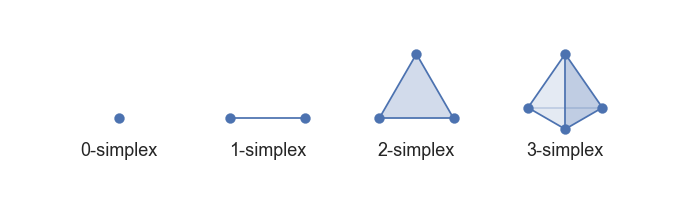

*An illustration of simplicies.*

In [ ]:
# # Doesn't appear to work in Colab :-(
# ! pip install babyplots
# from babyplots import Babyplot

# reducer2d = umap.UMAP(random_state=43, n_components=2)
# reducer3d = umap.UMAP(random_state=43, n_components=3)

# DF = df_yj.dropna(axis = 1).sample(frac = 0.05)
# y = DF["y"]
# DF = DF.drop(columns = "y") # Drop target

# embedding2d = reducer2d.fit_transform(DF.to_numpy())
# embedding3d = reducer3d.fit_transform(DF.to_numpy())

# bp = Babyplot()
# bp.add_plot(embedding3d, 
#             "pointCloud",
#             "categories",
#             y.tolist(),
#             {
#                 "colorscale": "Set2",
#                 "showLegend": True,
#                 "folded": True,
#                 "foldedEmbedding": embedding2d.tolist()
             
#             }
# )
# bp # Nothing is shown! :-(